In [1]:
import sys
import os

sys.path.append('../')

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.io import imread

from gen.load_data import load_data

In [3]:
from sklearn.utils import shuffle

train_df, valid_df, test_df = load_data('../data')

train_df = shuffle(train_df)
valid_df = shuffle(valid_df)

print(train_df.head())


                                                image                   id  \
851   ../data/Train/CameraRGB/episode_0008_000038.png  episode_0008_000038   
667                   ../data/Train/CameraRGB/205.png                  205   
2681  ../data/Train/CameraRGB/episode_0012_000261.png  episode_0012_000261   
139                    ../data/Train/CameraRGB/50.png                   50   
28    ../data/Train/CameraRGB/episode_0004_000174.png  episode_0004_000174   

                                                label  
851   ../data/Train/CameraSeg/episode_0008_000038.png  
667                   ../data/Train/CameraSeg/205.png  
2681  ../data/Train/CameraSeg/episode_0012_000261.png  
139                    ../data/Train/CameraSeg/50.png  
28    ../data/Train/CameraSeg/episode_0004_000174.png  


In [4]:
from models.unet import model_unetVGG16

model = model_unetVGG16()
model.summary()

/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 416, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 320, 416, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 320, 416, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 160, 208, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [5]:
from gen.generators import gen_func, preprocess_label
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input

img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05)

rgb_gen = ImageDataGenerator(preprocessing_function=preprocess_input, **img_gen_args)
lab_gen = ImageDataGenerator(preprocessing_function = preprocess_label, **img_gen_args)

rgb_gen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
lab_gen2 = ImageDataGenerator(preprocessing_function = preprocess_label)

BATCH_SIZE=32

train_gen = gen_func(train_df, rgb_gen, lab_gen, image_size=(600, 800), target_size=(320, 416), batch_size = BATCH_SIZE)
valid_gen = gen_func(valid_df, rgb_gen2, lab_gen2, image_size=(600, 800), target_size=(320, 416), batch_size = BATCH_SIZE)
# test_and_lab_gen = gen_func(test_df, rgb_gen2, lab_gen2, image_size=(600, 800),  target_size=(480, 416), batch_size = BATCH_SIZE)

In [6]:
from train import weighted_categorical_crossentropy
from keras.utils.training_utils import multi_gpu_model
from keras_contrib.losses import jaccard_distance

weights = np.array([10, 5, 1])

gpus = 2

model_gpu = multi_gpu_model(model, gpus)
# model_gpu.load_weights('../saved_models/unet/model.hdf5')
model_gpu.compile(loss=weighted_categorical_crossentropy(weights),
              optimizer='adam',
              metrics=['accuracy', 'mse'])


In [7]:
from train import train_nn

model_dir = '../saved_models/unet'

m = train_df.shape[0]
history = train_nn(model_gpu, 
                   train_gen, 
                   valid_gen, 
                   training_size=m, 
                   batch_size=BATCH_SIZE,
                   validation_size=valid_df.shape[0],
                   output_path=model_dir, 
                   epochs=100,
                   gpus = 2)

Instructions for updating:
Use the retry module or similar alternatives.


/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
## Ignore next message from keras, values are replaced anyways
Reinserting dataframe: 500 images
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 500 images
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0

Epoch 24/100
75/75 [==============================] - 160s 2s/step - loss: 0.0459 - acc: 0.9894 - mean_squared_error: 0.0042 - val_loss: 0.0942 - val_acc: 0.9896 - val_mean_squared_error: 0.0051

Epoch 00024: val_loss did not improve
Epoch 25/100
75/75 [==============================] - 156s 2s/step - loss: 0.0431 - acc: 0.9898 - mean_squared_error: 0.0039 - val_loss: 0.0906 - val_acc: 0.9902 - val_mean_squared_error: 0.0048

Epoch 00025: val_loss did not improve
Epoch 26/100
75/75 [==============================] - 166s 2s/step - loss: 0.0435 - acc: 0.9898 - mean_squared_error: 0.0039 - val_loss: 0.0864 - val_acc: 0.9899 - val_mean_squared_error: 0.0048

Epoch 00026: val_loss did not improve
Epoch 27/100
75/75 [==============================] - 163s 2s/step - loss: 0.0425 - acc: 0.9900 - mean_squared_error: 0.0038 - val_loss: 0.0921 - val_acc: 0.9899 - val_mean_squared_error: 0.0050

Epoch 00027: val_loss did not improve
Epoch 28/100
75/75 [==============================] - 156s 2s/st

75/75 [==============================] - 160s 2s/step - loss: 0.0780 - acc: 0.9791 - mean_squared_error: 0.0094 - val_loss: 0.1827 - val_acc: 0.9677 - val_mean_squared_error: 0.0164

Epoch 00058: val_loss did not improve

Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
Epoch 59/100
75/75 [==============================] - 157s 2s/step - loss: 0.0770 - acc: 0.9794 - mean_squared_error: 0.0092 - val_loss: 0.2066 - val_acc: 0.9670 - val_mean_squared_error: 0.0175

Epoch 00059: val_loss did not improve


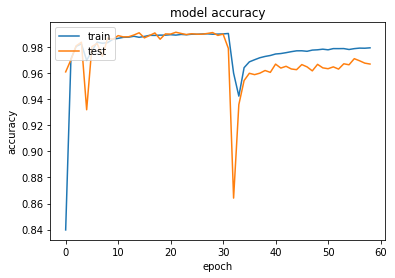

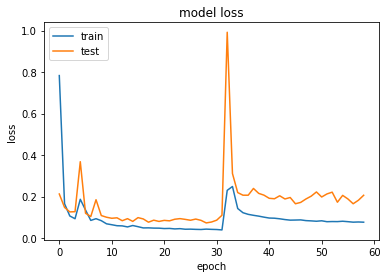

In [8]:
# # summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
model_gpu.load_weights('../saved_models/unet/model.hdf5')
model_gpu.layers[3].get_weights()[0]
# model.save('../saved_models/unet/model_saved.h5')
# model_gpu.save('../saved_models/unet/modelgpu.h5')
# model_gpu.compile(loss=weighted_categorical_crossentropy(weights),

array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
          -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
         [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
          -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
         [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
          -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],

        [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
          -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
         [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
          -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
         [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
          -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],

        [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
          -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
         [-8.13870355e-02,  4.18543853e-02, -1.01763301e-01, ...,
          -9.43124294e-02, -5.0566

In [71]:
print (model_gpu.layers[3].get_weights()[8].shape)

print (model.layers[7].get_weights()[0].shape)

(3, 3, 128, 256)
(3, 3, 128, 256)


In [73]:
from sklearn.metrics import mean_squared_error
from math import sqrt


rmse = mean_squared_error(model.layers[7].get_weights()[0].reshape(-1), model_gpu.layers[3].get_weights()[8].reshape(-1))
print (rmse)

0.0


In [74]:
model.save('../saved_models/unet/model_saved.h5')